# Peakfinder

## Introduction

This notebook takes input data from ASR-recordings in the form of an input folder containing the CSV files for each recording day and animal, giving output files regarding the average reaction of each animal to each experiment. <br>The code is annotated and a more extensive explanation is contained within `Protocol.pdf`. 

## Imports

If this is your first time running this, you may need to install various python packages using pip. <br>
Open the terminal, either the windows command console or the VSC terminal, and run the command `pip install MODULENAME` for every module listed in the cell below (for example, `pip install pandas` to install pandas). Some of them may already be installed. Repeat this for the imports in `Analyzer.ipynb`.

In [80]:
import pandas as pd       
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict, Counter
from IPython.display import clear_output
import re
from scipy.optimize import curve_fit
from scipy.integrate import simpson

## Configuration

In [81]:
input_dir = "2025" # - - - - - - - - - - - - - - - - - - - - - - - - - - folder containing folders with .CSV files; change this to your own input directory

output_dir = "Results" # - - - - - - - - - - - - - - - - - - - - - - - - folder containing final results

filenames = ["OVERVIEW", "RESULTS", "RESULTS_TT", "RESULTS_MTT"] # - - - result file names (overview, main results, top 10 results, results minus the top 10)

verbose = True # - - - - - - - - - - - - - - - - - - - - - - - - - - - - enables more output messages which can help identify problems; the notebook will only return errors if False

discard_peakless = True # - - - - - - - - - - - - - - - - - - - - - - -  discard recordings without peaks from analysis

include_decay_fit = False # - - - - - - - - - - - - - - - - - - - - - -  include regular exponential decay in the output

replace = False # - - - - - - - - - - - - - - - - - - - - - - - - - - -  replace last output instead of making a new one

output = False # - - - - - - - - - - - - - - - - - - - - - - - - - - - -  output results; set to False for testing if you do not want any change in output files when running the notebook

detection_threshold = 24 # - - - - - - - - - - - - - - - - - - - - - - - threshold multiplier for detecting peaks, ValueG has to exceed k times the background noise per animal

RT_threshold = 6 # - - - - - - - - - - - - - - - - - - - - - - - - - - - threshold multiplier for measuring reaction time, ValueG has to exceed k times the background noise per animal

length = 500 # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - length of the time window in milliseconds (both before and after the startle)

example_number = 33 # - - - - - - - - - - - - - - - - - - - - - - - - -  index of the trial used for the example plot

background_offset = 200 # - - - - - - - - - - - - - - - - - - - - - - -  measure background noise up to this many ms before the startle time (increase if a prepulse is played this or further away from the startle)

detection_offset = 100 # - - - - - - - - - - - - - - - - - - - - - - - - check for signal up to this many ms after the startle time (for detection)

measurement_offset = 500 # - - - - - - - - - - - - - - - - - - - - - - - check for signal up to this many ms after the startle time (for measurement)

#exclude = ["offset_PPI", "offset_ASR"] # - - - - - - - - - - - - - - -  experiment types to be excluded from analysis
#exclude = ["ASR_control", "gap_depth"]
exclude = None

In [82]:
# Input startle times for every experiment
startle_times = {

    "ASR_control":      10000,
    "gap_depth":        10100,
    "gap_duration_10":  10060,
    "gap_duration_20":  10070,
    "gap_duration_4":   10054,
    "gap_duration_50":  10100,
    "gap_duration_8":   10058,
    "offset_ASR":       10010,
    "offset_PPI_10":    10010,
    "offset_PPI_12":    10012,
    "offset_PPI_14":    10014,
    "offset_PPI_16":    10016,
    "offset_PPI_18":    10018,
    "offset_PPI_20":    10020,
    "offset_PPI_4":     10004,
    "offset_PPI_6":     10006,
    "offset_PPI_8":     10008,
    "offset_PPI_50":    10050,
    "tone_in_noise":    10100
    
}

In [83]:
# Input sex for every animal
sex_dict = {
    "1":    "female",
    "2":    "male",
    "4":    "male",
    "6":    "female",
    "10":   "female",
    "15":   "male"
}

In [84]:
# CSV file settings (insert columns like how they'd appear in an excel file, as in starting with column 1)

data_start =           5   # row where recording data starts

animal_column =        2   # column "Animal. No."
experiment_column =    8   # column "Exp. No."
weight_column =        6   # column "Weight"
number_column =        18  # column "TrialNo"
name_column =          17  # column "Trial"
time_column =          19  # column "MS"
value_column =         20  # column "ValueG"

# adjust columns to be 0-indexed
experiment_column, weight_column, number_column, name_column, time_column, value_column = (x - 1 for x in (experiment_column, weight_column, number_column, name_column, time_column, value_column))

## Slicing

In [85]:
segments = {}
startles = {}

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith('.csv'):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path, low_memory=False, skiprows=[0, 2])

            animal_number = df.iloc[data_start + 1, animal_column]
            date = file[:-4].split('_')[1]
            animal_str = f"Animal{animal_number}"

            df.iloc[:, value_column] = pd.to_numeric(df.iloc[:, value_column], errors='coerce')

            df.iloc[:, value_column] = abs(df.iloc[:, value_column])

            df['trial'] = df.iloc[:, name_column]
            df['trial_shift'] = df['trial'].shift(1)
            df['new_segment'] = df['trial'] != df['trial_shift']
            df['segment_id'] = df['new_segment'].cumsum()

            repetition = {}

            for segment_id, segment_df in df.groupby('segment_id'):
                trial_name = segment_df.iloc[0]['trial']
                repetition[trial_name] = repetition.get(trial_name, 0) + 1

                segment_startle = startle_times.get(trial_name)
                if segment_startle is None:
                    raise Exception(f"Missing startle time for {trial_name}. Please make sure it is included in the startle_times dictionary.")

                segment_name = f"{animal_str}_{date}_{trial_name}_Rep{repetition[trial_name]}"

                segment_length = len(segment_df)
                time_col = np.arange(0, segment_length * 2, 2)
                segment_data = pd.DataFrame({
                    0: time_col,
                    1: segment_df.iloc[:, value_column].values
                })

                segments[segment_name] = segment_data
                startles[segment_name] = segment_startle

counts = Counter([segment_df.iloc[0]['trial'] for _, segment_df in df.groupby('segment_id')])

clear_output(wait=False)

if verbose: 
    print(f"Processed {len(segments)} segments.") # 1710 expected
    print("Repetition count per experiment:")
    for name, count in sorted(counts.items()):
        print(f"{name}: {count}") # 5 each expected

Processed 1645 segments.
Repetition count per experiment:
ASR_control: 5
gap_depth: 5
gap_duration_10: 5
gap_duration_20: 5
gap_duration_4: 5
gap_duration_50: 5
gap_duration_8: 5
offset_ASR: 5
offset_PPI_10: 5
offset_PPI_12: 5
offset_PPI_14: 5
offset_PPI_16: 5
offset_PPI_18: 3
offset_PPI_20: 4
offset_PPI_4: 5
offset_PPI_50: 4
offset_PPI_6: 4
offset_PPI_8: 5
tone_in_noise: 5


In [86]:
# Get background noise per animal
animal_noise_results = {}

experiment_keys = [t[0] for t in sorted(counts.items())]

for key in segments.keys():
    # Extract animal name
    animal = key.split('_')[0]

    # Find experiment prefix in key
    matching_prefix = None
    for exp_key in experiment_keys:
        if exp_key in key:
            matching_prefix = exp_key
            break

    if matching_prefix is None:
        print(f"No experiment prefix found for key: {key}")
        continue

    startle_time = startle_times.get(matching_prefix)
    if startle_time is None:
        print(f"No startle time found for experiment: {matching_prefix}")
        continue

    df = segments[key]

    # Convert time column to numeric
    df.iloc[:, 0] = pd.to_numeric(df.iloc[:, 0], errors='coerce')

    start_time = 0
    end_time = startle_time - background_offset  # measure up to 200ms before the startle
    if end_time <= start_time:
        print(f"Invalid time window for {key}: startle_time={startle_time}")
        continue

    mask = (df.iloc[:, 0] >= start_time) & (df.iloc[:, 0] < end_time)
    background_window = df.loc[mask].iloc[:, 1]

    if background_window.empty:
        print(f"No data in background window for {key}")
        continue

    noise_level = background_window.std()

    # Store noise levels per animal and experiment across repetitions
    animal_noise_results.setdefault(animal, {}).setdefault(matching_prefix, []).append(noise_level)

# Median noise across repetitions per experiment per animal
animal_noise_median = {}
for animal, exp_dict in animal_noise_results.items():
    animal_noise_median[animal] = {}
    for exp, noise_list in exp_dict.items():
        animal_noise_median[animal][exp] = float(np.median(noise_list))

# Median noise across experiments per animal
animal_noise = {}
for animal, exp_dict in animal_noise_median.items():
    all_exp_values = list(exp_dict.values())
    if all_exp_values:
        animal_noise[animal] = round(float(np.median(all_exp_values)), 2)
    else:
        animal_noise[animal] = None

if verbose:
    print(f"Collected background noise for {len(animal_noise)} animals:")
    print(animal_noise)


Collected background noise for 6 animals:
{'Animal10': 0.42, 'Animal15': 1.04, 'Animal1': 0.51, 'Animal2': 0.45, 'Animal4': 0.58, 'Animal6': 0.42}


In [87]:
# Cut the segments
adjusted_segments = {}
for entry in segments:
    df = segments[entry]
    reference_time = startles[entry]  

    # Filter the data to get rows within the 1000 ms before and after the reference time
    start_time = reference_time - length
    end_time = reference_time + length

    # Filter the dataframe to include only the data within the time range
    filtered_df = df[(df.iloc[:, 0] >= start_time) & (df.iloc[:, 0] <= end_time)].copy()

    # Adjust the time column to set the reference time to 0
    filtered_df.iloc[:, 0] = filtered_df.iloc[:, 0] - reference_time

    filtered_df.reset_index(drop=True, inplace=True) 

    adjusted_segments[entry] = filtered_df

if verbose: print(f"Adjusted {len(adjusted_segments)} segments.")

Adjusted 1645 segments.


In [88]:
# Find top 10 recordings
animal_date_keys = defaultdict(list)
minus_top_10_keys = list(adjusted_segments.keys())

for key in adjusted_segments.keys():
    parts = key.split('_')
    animal = parts[0]
    date = parts[1]
    animal_date_keys[(animal, date)].append(key)

# Take first 10 keys per animal per date
top_10_keys = []
for (animal, date), keys in animal_date_keys.items():
    first_10_keys = keys[:10]
    top_10_keys.extend(first_10_keys)

# Remove top 10 entries per animal and day from minus top 10 keyset
for key in minus_top_10_keys: 
    if key in top_10_keys: 
        minus_top_10_keys.remove(key)

if verbose: print(f"Found {len(top_10_keys)} segments for the first ten recordings.")

Found 180 segments for the first ten recordings.


In [89]:
print(top_10_keys)
print(len(minus_top_10_keys))
print(len(adjusted_segments))

['Animal10_April16_gap_duration_4_Rep1', 'Animal10_April16_gap_depth_Rep1', 'Animal10_April16_offset_PPI_4_Rep1', 'Animal10_April16_offset_PPI_50_Rep1', 'Animal10_April16_offset_PPI_8_Rep1', 'Animal10_April16_offset_PPI_14_Rep1', 'Animal10_April16_offset_PPI_6_Rep1', 'Animal10_April16_offset_ASR_Rep1', 'Animal10_April16_gap_duration_10_Rep1', 'Animal10_April16_offset_PPI_12_Rep1', 'Animal10_June26_offset_PPI_14_Rep1', 'Animal10_June26_offset_PPI_50_Rep1', 'Animal10_June26_offset_PPI_4_Rep1', 'Animal10_June26_gap_depth_Rep1', 'Animal10_June26_offset_PPI_16_Rep1', 'Animal10_June26_offset_PPI_18_Rep1', 'Animal10_June26_tone_in_noise_Rep1', 'Animal10_June26_gap_duration_10_Rep1', 'Animal10_June26_ASR_control_Rep1', 'Animal10_June26_gap_depth_Rep2', 'Animal10_May20_offset_PPI_4_Rep1', 'Animal10_May20_gap_duration_4_Rep1', 'Animal10_May20_offset_PPI_10_Rep1', 'Animal10_May20_offset_PPI_4_Rep2', 'Animal10_May20_gap_duration_20_Rep1', 'Animal10_May20_offset_PPI_20_Rep1', 'Animal10_May20_offset

In [90]:
if exclude is not None:
    before = len(adjusted_segments)
    # Remove excluded experiments
    for key in adjusted_segments.keys():
        adjusted_segments = {   # remove excluded keys
        key: value
        for key, value in adjusted_segments.items()
        if not any(word in key for word in exclude)
    }
    if verbose: print(f"Excluded {before-len(adjusted_segments)} segments.")

## Signal Detection

In [91]:
animal_thresholds = {animal: animal_noise[animal] * RT_threshold for animal in animal_noise}
animal_thresholds_det = {animal: animal_noise[animal] * detection_threshold for animal in animal_noise}

In [92]:
print(f"Animal thresholds for reaction time: {animal_thresholds}")
print(f"Animal thresholds for detection: {animal_thresholds_det}")

Animal thresholds for reaction time: {'Animal10': 2.52, 'Animal15': 6.24, 'Animal1': 3.06, 'Animal2': 2.7, 'Animal4': 3.4799999999999995, 'Animal6': 2.52}
Animal thresholds for detection: {'Animal10': 10.08, 'Animal15': 24.96, 'Animal1': 12.24, 'Animal2': 10.8, 'Animal4': 13.919999999999998, 'Animal6': 10.08}


In [93]:
signal_results = {}

for key, df in adjusted_segments.items():
    animal = key.split('_')[0]
    noise = animal_noise.get(animal)

    # Set post-startle window
    mask = (df.iloc[:, 0] >= 0) & (df.iloc[:, 0] <= detection_offset)
    window = df.loc[mask].iloc[:, 1]

    # Threshold detection
    detected = not window.empty and window.max() > detection_threshold * noise
    signal_results[key] = detected

if verbose: print(signal_results)

{'Animal10_April16_gap_duration_4_Rep1': np.True_, 'Animal10_April16_gap_depth_Rep1': np.True_, 'Animal10_April16_offset_PPI_4_Rep1': np.True_, 'Animal10_April16_offset_PPI_50_Rep1': np.True_, 'Animal10_April16_offset_PPI_8_Rep1': np.True_, 'Animal10_April16_offset_PPI_14_Rep1': np.True_, 'Animal10_April16_offset_PPI_6_Rep1': np.True_, 'Animal10_April16_offset_ASR_Rep1': np.False_, 'Animal10_April16_gap_duration_10_Rep1': np.True_, 'Animal10_April16_offset_PPI_12_Rep1': np.True_, 'Animal10_April16_offset_ASR_Rep2': np.False_, 'Animal10_April16_offset_PPI_16_Rep1': np.True_, 'Animal10_April16_offset_PPI_4_Rep2': np.True_, 'Animal10_April16_gap_depth_Rep2': np.True_, 'Animal10_April16_offset_PPI_12_Rep2': np.True_, 'Animal10_April16_offset_PPI_10_Rep1': np.True_, 'Animal10_April16_offset_PPI_18_Rep1': np.True_, 'Animal10_April16_offset_PPI_4_Rep3': np.True_, 'Animal10_April16_gap_duration_10_Rep2': np.True_, 'Animal10_April16_offset_PPI_50_Rep2': np.True_, 'Animal10_April16_gap_duration_

In [94]:
animal_hits = {}
animal_misses = {}

for key, detected in signal_results.items():
    animal = key.split('_')[0]
    if detected:
        animal_hits[animal] = animal_hits.get(animal, 0) + 1
    else:
        animal_misses[animal] = animal_misses.get(animal, 0) + 1

animal_hit_rate = {}
for animal in animal_hits.keys() | animal_misses.keys():
    hits = animal_hits.get(animal, 0)
    misses = animal_misses.get(animal, 0)
    total = hits + misses
    animal_hit_rate[animal] = round(hits / total, 2) if total > 0 else None

if verbose: print(animal_hit_rate)

{'Animal15': 0.89, 'Animal10': 0.94, 'Animal2': 0.95, 'Animal1': 0.94, 'Animal6': 0.95, 'Animal4': 0.94}


In [95]:
# Remove entries without peaks and collect their analysis
peakless_reaction = {}

if discard_peakless:
    excluded = []
    for k, df in adjusted_segments.items():
        if not signal_results.get(k, False):
            parts = k.split('_')
            animal = parts[0]
            date = parts[1]
            experiment_parts = []
            for p in parts[2:]:
                if p.startswith("Rep"):
                    break
                experiment_parts.append(p)
            experiment = "_".join(experiment_parts)
            rep = [p for p in parts if p.startswith("Rep")]
            rep_str = rep[0] if rep else ""
            excluded.append((animal, date, experiment, rep_str))

            # --- Run peak decay analysis even for peakless ---
            times = df[0]
            values = df[1]
            time_window_mask = (times >= 0) & (times <= measurement_offset)
            values_in_window = values[time_window_mask]
            times_in_window = times[time_window_mask]

            # Try to run decay fit on the whole window (no peak)
            tau = np.nan
            auc = np.nan
            peak_decay_tau = np.nan
            peak_decay_auc = np.nan
            reaction_time = np.nan
            peak_time = np.nan
            difference = np.nan
            peak_value = np.nan

            # Attempt to find peak values even if not detected by threshold
            if len(times_in_window) > 0:
                max_index_in_window = np.argmax(values_in_window)
                peak_value = values_in_window.iloc[max_index_in_window]
                peak_time = times_in_window.iloc[max_index_in_window]
                reaction_time = 0  # No threshold crossing, so set to 0 or np.nan
                difference = peak_time - reaction_time

            if len(times_in_window) > 5:
                try:
                    p0 = [np.max(values_in_window), 100, np.min(values_in_window)]
                    params, _ = curve_fit(exp_decay, times_in_window, values_in_window, p0=p0, maxfev=10000)
                    A, tau, C = params
                    fitted_curve = exp_decay(times_in_window, A, tau, C)
                    auc = simpson(fitted_curve, x=times_in_window)

                    # Peak decay fit (values above fit)
                    peak_mask = values_in_window > fitted_curve
                    if np.sum(peak_mask) > 5:
                        times_peak_decay = times_in_window[peak_mask]
                        values_peak_decay = values_in_window[peak_mask]
                        try:
                            p0_peak = [np.max(values_peak_decay), 100, np.min(values_peak_decay)]
                            params_peak, _ = curve_fit(exp_decay, times_peak_decay, values_peak_decay, p0=p0_peak, maxfev=10000)
                            A_peak, tau_peak, C_peak = params_peak
                            fitted_peak_curve = exp_decay(times_peak_decay, A_peak, tau_peak, C_peak)
                            peak_decay_auc = simpson(fitted_peak_curve, x=times_peak_decay)
                            peak_decay_tau = tau_peak
                        except Exception as e:
                            if verbose:
                                print(f"Peak decay fit failed for peakless {k}: {e}")
                except Exception as e:
                    if verbose:
                        print(f"Decay fit failed for peakless {k}: {e}")

            peakless_reaction[k] = {
                "reactionTime": [round(float(reaction_time), 2) if not pd.isna(reaction_time) else np.nan],
                "peakTime": [round(float(peak_time), 2) if not pd.isna(peak_time) else np.nan],
                "difference": [round(float(difference), 2) if not pd.isna(difference) else np.nan],
                "peakValue": [round(float(peak_value), 2) if not pd.isna(peak_value) else np.nan],
                "RMS": [round(float(np.sqrt(np.mean(np.square(values_in_window)))), 2) if len(values_in_window) > 0 else np.nan],
                "decayTau": [round(float(tau), 2)],
                "decayAUC": [round(float(auc), 2)],
                "peakDecayTau": [round(float(peak_decay_tau), 2)],
                "peakDecayAUC": [round(float(peak_decay_auc), 2)]
            }

    data = {k: v for k, v in adjusted_segments.items() if signal_results.get(k, False)}
    if verbose:
        print(f"Removed {len(adjusted_segments)-len(data)} entries without peaks from dataset.")
        from collections import Counter
        summary = Counter([(animal, date, experiment) for animal, date, experiment, _ in excluded])
        print("Exclusion summary (animal, date, experiment):")
        for (animal, date, experiment), count in summary.items():
            reps = [rep for a, d, e, rep in excluded if a == animal and d == date and e == experiment]
            print(f"  {animal}, {date}, {experiment}: {count} excluded (reps: {', '.join(reps)})")
else:
    data = adjusted_segments

# Save peakless results as RESULTS_PEAKLESS.xlsx
if len(peakless_reaction) > 0:
    def build_results_peakless(reaction_dict):
        results = []
        for entry, metrics in reaction_dict.items():
            parts = entry.split('_')
            animal = parts[0]
            date = parts[1]
            experiment_parts = []
            for p in parts[2:]:
                if p.startswith("Rep"):
                    break
                experiment_parts.append(p)
            experiment = "_".join(experiment_parts)
            rep = [p for p in parts if p.startswith("Rep")]
            rep_str = rep[0] if rep else ""
            result = {
                "animal": animal,
                "date": date,
                "experiment": experiment,
                "rep": rep_str,
                **{k: metrics[k][0] for k in metrics}
            }
            results.append(result)
        return results

    peakless_df = pd.DataFrame(build_results_peakless(peakless_reaction))
    output_dir_final = output_dir if output else "."
    os.makedirs(output_dir_final, exist_ok=True)
    peakless_df.to_excel(os.path.join(output_dir_final, "RESULTS_PEAKLESS.xlsx"), index=False)
    if verbose:
        print(f"Saved peakless results to {os.path.join(output_dir_final, 'RESULTS_PEAKLESS.xlsx')}")

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Galahad\AppData\Local\Temp\ipykernel_26908\71535695.py:49: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(exp_decay, times_in_window, values_in_window, p0=p0, maxfev=10000)


Removed 111 entries without peaks from dataset.
Exclusion summary (animal, date, experiment):
  Animal10, April16, offset_ASR: 5 excluded (reps: Rep1, Rep2, Rep3, Rep4, Rep5)
  Animal10, June26, offset_ASR: 5 excluded (reps: Rep1, Rep2, Rep3, Rep4, Rep5)
  Animal10, May20, offset_ASR: 5 excluded (reps: Rep1, Rep2, Rep3, Rep4, Rep5)
  Animal10, May20, offset_PPI_12: 1 excluded (reps: Rep2)
  Animal10, May20, offset_PPI_14: 1 excluded (reps: Rep4)
  Animal15, April16, offset_ASR: 5 excluded (reps: Rep1, Rep2, Rep3, Rep4, Rep5)
  Animal15, April16, offset_PPI_10: 3 excluded (reps: Rep1, Rep3, Rep5)
  Animal15, April16, offset_PPI_16: 1 excluded (reps: Rep2)
  Animal15, April16, offset_PPI_18: 1 excluded (reps: Rep3)
  Animal15, April16, tone_in_noise: 1 excluded (reps: Rep2)
  Animal15, April16, offset_PPI_8: 1 excluded (reps: Rep5)
  Animal15, April16, gap_duration_4: 1 excluded (reps: Rep5)
  Animal15, April16, gap_duration_20: 1 excluded (reps: Rep5)
  Animal15, June26, offset_ASR: 5 e

## Analysis

In [96]:
def exp_decay(t, A, tau, C):
    return A * np.exp(-t / tau) + C

main_reaction = {}

for entry in data:
    times = data[entry][0]
    values = data[entry][1]

    # Fixed window
    time_window_mask = (times >= 0) & (times <= measurement_offset)
    values_in_window = values[time_window_mask]
    times_in_window = times[time_window_mask]

    indices_above_threshold = np.where((values > animal_thresholds[entry.split("_")[0]]) & (times > 0))[0]

    if len(indices_above_threshold) > 0:
        peak_start = times[indices_above_threshold[0]]

        max_index_in_window = np.argmax(values_in_window)
        max_value = values_in_window.iloc[max_index_in_window]
        max_time = times_in_window.iloc[max_index_in_window]

        buildup = max_time - peak_start
        rms_value = np.sqrt(np.mean(np.square(values_in_window)))

        # --- POST-PEAK decay analysis ---
        decay_mask = (times > max_time)
        times_decay = times[decay_mask] - max_time
        values_decay = values[decay_mask]

        tau = np.nan
        auc = np.nan
        peak_decay_tau = np.nan
        peak_decay_auc = np.nan

        if len(times_decay) > 5:
            try:
                p0 = [max_value, 100, np.min(values_decay)]
                params, _ = curve_fit(exp_decay, times_decay, values_decay, p0=p0, maxfev=10000)
                A, tau, C = params

                fitted_curve = exp_decay(times_decay, A, tau, C)
                auc = simpson(fitted_curve, x=times_decay)

                # --- PEAK DECAY analysis ---
                peak_mask = values_decay > fitted_curve
                if np.sum(peak_mask) > 5:
                    times_peak_decay = times_decay[peak_mask]
                    values_peak_decay = values_decay[peak_mask]
                    try:
                        p0_peak = [np.max(values_peak_decay), 100, np.min(values_peak_decay)]
                        params_peak, _ = curve_fit(exp_decay, times_peak_decay, values_peak_decay, p0=p0_peak, maxfev=10000)
                        A_peak, tau_peak, C_peak = params_peak
                        fitted_peak_curve = exp_decay(times_peak_decay, A_peak, tau_peak, C_peak)
                        peak_decay_auc = simpson(fitted_peak_curve, x=times_peak_decay)
                        peak_decay_tau = tau_peak
                    except Exception as e:
                        if verbose:
                            print(f"Peak decay fit failed for {entry}: {e}")
            except Exception as e:
                if verbose:
                    print(f"Decay fit failed for {entry}: {e}")

        # Save result
        main_reaction[entry] = {
            "reactionTime": [int(peak_start)],
            "peakTime": [int(max_time)],
            "difference": [int(buildup)],
            "peakValue": [int(max_value)],
            "RMS": [round(float(rms_value), 2)],
            "decayTau": [round(float(tau), 2)],
            "decayAUC": [round(float(auc), 2)],
            "peakDecayTau": [round(float(peak_decay_tau), 2)],
            "peakDecayAUC": [round(float(peak_decay_auc), 2)]
        }

    else:
        if discard_peakless:
            raise ValueError(f"No peak found for {entry}, something went really really wrong.")

if verbose: print(f"Created reaction data for {len(main_reaction)} segments.")

Created reaction data for 1534 segments.


In [97]:
top_10_reaction = {}
minus_top_10_reaction = {}

for key in top_10_keys:
    if key in main_reaction: top_10_reaction[key] = main_reaction[key]
for key in minus_top_10_keys:
    if key in main_reaction: minus_top_10_reaction[key] = main_reaction[key]

## Saving

In [98]:
# Build intermediate dicts for each dataset
def build_intermediate(reaction_dict):
    intermediate = defaultdict(lambda: {k: [] for k in [
        "animal", "sex", "date", "reactionTime", "peakTime", "difference", "peakValue", "RMS",
        "decayTau", "decayAUC", "peakDecayTau", "peakDecayAUC"
    ]})
    for entry, values in reaction_dict.items():
        parts = entry.split("_")
        animal, date = parts[0], parts[1]
        sex = sex_dict[animal.replace("Animal", "")]
        experiment = "_".join([p for p in parts[2:] if not p.lower().startswith("rep")])
        key = f"{animal}_{date}_{experiment}"
        intermediate[key]["animal"] = animal
        intermediate[key]["sex"] = sex
        intermediate[key]["date"] = date
        for k in intermediate[key]:
            if k in values:
                intermediate[key][k].extend(values[k] if isinstance(values[k], list) else [values[k]])
    return intermediate

intermediate_main = build_intermediate(main_reaction)
intermediate_top_10 = build_intermediate(top_10_reaction)
intermediate_minus_top_10 = build_intermediate(minus_top_10_reaction)

# Overview only for main
overview = [
    {
        "animal": key.split("_")[0],
        "sex": sex_dict[key.split("_")[0].replace("Animal", "")],
        "experiment": "_".join(key.split("_")[2:]),
        **{k: round(np.mean([
            sum(metrics[k])/len(metrics[k]) if len(metrics[k]) > 0 else np.nan
            for key2, metrics in intermediate_main.items()
            if key2.split("_")[0] == key.split("_")[0]
            and "_".join(key2.split("_")[2:]) == "_".join(key.split("_")[2:])
            and sex_dict[key2.split("_")[0].replace("Animal", "")] == sex_dict[key.split("_")[0].replace("Animal", "")]
        ]), 2)
        for k in metrics if k not in ["animal", "sex", "date"]}
    }
    for key, metrics in intermediate_main.items()
    if key.split("_")[1] == min([k.split("_")[1] for k in intermediate_main if
        k.split("_")[0] == key.split("_")[0] and "_".join(k.split("_")[2:]) == "_".join(key.split("_")[2:])])
]

# Results for each dataset
def build_results(intermediate):
    return [
        {
            "animal": key.split("_")[0],
            "sex": sex_dict[key.split("_")[0].replace("Animal", "")],
            "date": key.split("_")[1],
            "experiment": "_".join(key.split("_")[2:]),
            **{k: metrics[k] for k in metrics if k not in ["animal", "sex", "date"]}
        }
        for key, metrics in intermediate.items()
    ]

results = build_results(intermediate_main)
results_top_10 = build_results(intermediate_top_10)
results_minus_top_10 = build_results(intermediate_minus_top_10)

In [99]:
def plot_segment(name, segments, reaction):
    if name not in segments or name not in reaction:
        print(f"{name} not found in segments or reaction data.")
        return

    df = segments[name]
    times = df[0]
    values = df[1]
    startle_x = 0

    animal = name.split("_")[0]
    plot_noise = animal_noise.get(animal)
    plot_threshold_1 = plot_noise * detection_threshold 
    plot_threshold_2 = animal_thresholds[animal]

    # Extract analysis results
    metrics = reaction[name]
    peak_time = metrics.get("peakTime", [None])[0]
    peak_value = metrics.get("peakValue", [None])[0]
    decay_tau = metrics.get("decayTau", [None])[0] 
    peak_decay_tau = metrics.get("peakDecayTau", [None])[0]

    plt.figure(figsize=(8, 6))
    plt.plot(times, values, color="#000000", linewidth=1, label="Signal")

    # --- Threshold & timing markers ---
    plt.axvline(x=startle_x, color="#FF0000", linewidth=2, linestyle='dotted', label="Startle")
    plt.axvline(x=measurement_offset, color="#FFD000", linewidth=2, linestyle='dotted',
                label=f"Measurement End (t={measurement_offset}ms)")

    plt.axhline(y=plot_threshold_1, color="#CE1195", linewidth=2, linestyle='dotted',
                label=f"Detection Threshold (k={detection_threshold})")
    plt.axhline(y=plot_threshold_2, color="#11CE4A", linewidth=2, linestyle='dotted',
                label=f"Measurement Threshold (k={RT_threshold})")
    plt.axhline(y=plot_noise, color="#6F52BF", linewidth=2, linestyle='dotted',
                label=f"Background Noise ({plot_noise:.2f})")

    # --- Mark peak ---
    if peak_time is not None and peak_value is not None:
        plt.plot(peak_time, peak_value, 'ro', label=f"Peak ({peak_time}ms, {peak_value})")
        plt.axvline(x=peak_time, color="#AA0000", linewidth=1.5, linestyle='--')

    # --- Plot fitted decay curve ---
    if decay_tau is not None and not np.isnan(decay_tau) and peak_time is not None and peak_value is not None:
        try:
            decay_mask = times > peak_time
            decay_times = times[decay_mask]
            decay_values = values[decay_mask]
            shifted_times = decay_times - peak_time

            # Estimate fit again with starting params
            p0 = [peak_value, decay_tau, np.min(decay_values)]
            params, _ = curve_fit(exp_decay, shifted_times, decay_values, p0=p0, maxfev=10000)
            A, tau, C = params

            fitted = exp_decay(shifted_times, A, tau, C)
            plt.plot(decay_times, fitted, 'r--', label=f"Decay Fit (τ={tau:.2f}ms)")

            # --- Plot peak decay fit ---
            if peak_decay_tau is not None and not np.isnan(peak_decay_tau):
                peak_mask = decay_values > fitted
                if np.sum(peak_mask) > 5:
                    times_peak_decay = shifted_times[peak_mask]
                    values_peak_decay = decay_values[peak_mask]
                    try:
                        p0_peak = [np.max(values_peak_decay), peak_decay_tau, np.min(values_peak_decay)]
                        params_peak, _ = curve_fit(exp_decay, times_peak_decay, values_peak_decay, p0=p0_peak, maxfev=10000)
                        A_peak, tau_peak, C_peak = params_peak
                        fitted_peak = exp_decay(times_peak_decay, A_peak, tau_peak, C_peak)
                        plt.plot(decay_times[peak_mask], fitted_peak, 'b--', label=f"Peak Decay Fit (τ={tau_peak:.2f}ms)")
                    except Exception as e:
                        print(f"Peak decay fitting failed for {name}: {e}")

        except Exception as e:
            print(f"Decay fitting failed for {name}: {e}")

    plt.xlabel("Time (ms)", fontsize=12)
    plt.ylabel("ValueG", fontsize=12)
    plt.title(name, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

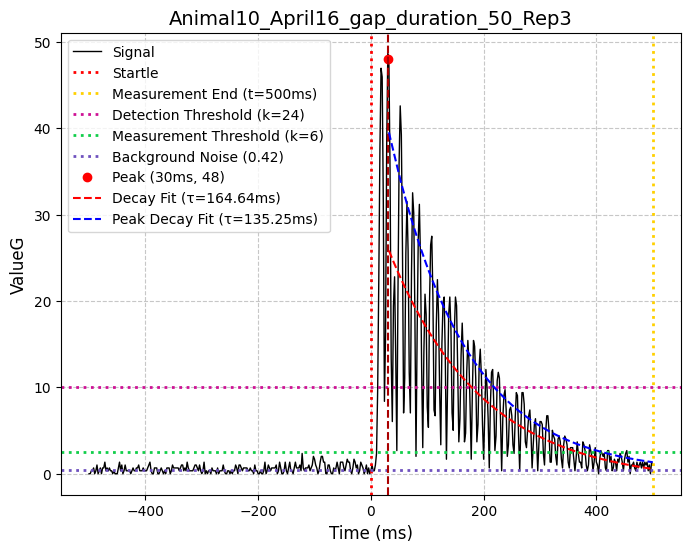

In [100]:
example_name = list(data.keys())[example_number] # get example segment
plot_segment(example_name, data, main_reaction) # plot example segment

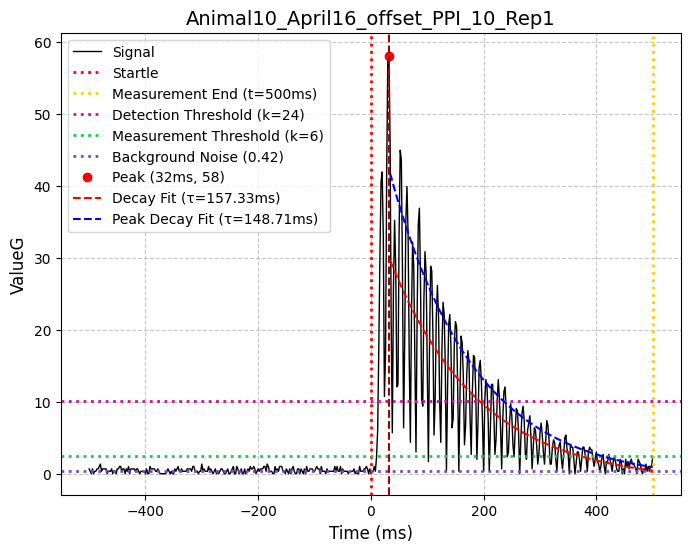

In [101]:
plot_segment("Animal10_April16_offset_PPI_10_Rep1", data, main_reaction)

In [102]:
def get_number(s):
    match = re.search(r'(\d+)$', s)  
    return int(match.group(1)) if match else None

def get_experiment_type(s):
    return re.sub(r'[_\s-]?\d+$', '', s)

def get_animal_number(s):
    match = re.search(r'(\d+)', s)
    return int(match.group(1)) if match else None

In [103]:
if output:
    os.makedirs(output_dir, exist_ok=True)

    counter = 1
    while os.path.exists(os.path.join(output_dir, str(counter))):
        counter += 1

    if replace and counter != 1: counter -= 1

    subfolder_path = os.path.join(output_dir, str(counter))

    os.makedirs(subfolder_path, exist_ok=True)

    dfs = [pd.DataFrame(overview), pd.DataFrame(results), pd.DataFrame(results_top_10), pd.DataFrame(results_minus_top_10)]

    for i, df in enumerate(dfs):
        # Sorting
        df['has_number'] = df['experiment'].str.contains(r'\d+$')
        df['experiment_number'] = df['experiment'].apply(get_number)
        df['experiment_type'] = df['experiment'].apply(get_experiment_type)
        df['animal_number'] = df['animal'].apply(get_animal_number)
        try:
            df = df.sort_values(['date', 'animal_number', 'has_number', 'experiment_type', 'experiment_number'])
        except KeyError:
            df = df.sort_values(['animal_number', 'has_number', 'experiment_type', 'experiment_number'])

        df = df.drop(columns=['has_number', 'experiment_type', 'experiment_number', 'animal_number'])

        if not include_decay_fit:
            df = df.drop(columns=['decayTau', 'decayAUC'])
            df = df.rename(columns={'peakDecayTau': 'tau', 'peakDecayAUC': 'AUC'}) 

        df = df.reset_index(drop=True)

        # Naming and saving
        filename = filenames[i]
        output_path = os.path.join(subfolder_path, f"{filename}.xlsx")

        df.to_excel(output_path, index=False)

    if verbose: print(f"Saved results to: {subfolder_path}")